# Proyek Klasifikasi Gambar: Raw Animals-10 Dataset by Corrado Alessio ( Kaggle )
- **Nama:** Satria Ego Vania
- **Email:** satriaego.21038@mhs.unesa.ac.id
- **ID Dicoding:** satriaegovania

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install split-folders
!pip install tensorflowjs
import zipfile
import os
import splitfolders
from PIL import Image
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Preparation

### Dataset Download

In [2]:
%%bash
curl -L -o ./animal10.zip \
https://www.kaggle.com/api/v1/datasets/download/alessiocorrado99/animals10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  585M  100  585M    0     0  20.1M      0  0:00:29  0:00:29 --:--:-- 22.4M


### Ekstraksi Dataset

In [3]:
# 1. Menentukan file sumber dan tujuan ekstraksi
local_zip = './animal10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

# 2. Ekstraksi ke folder 'rice_data'
zip_ref.extractall('./animal10')
zip_ref.close()


## Data Loading

### Melihat Sebaran Data

In [4]:
base_dir = './animal10/raw-img'
total_all = 0

print("📂 animal10/raw-img")
print("."* 3+'\n')

folders = sorted(os.listdir(base_dir))
for i, folder in enumerate(folders):
    connector = "-"

    path = os.path.join(base_dir, folder)
    num_files = len(os.listdir(path))
    total_all += num_files

    print(f"{connector} 📂 {folder:<12} ({num_files} images)")

print(f"\nTotal images: {total_all}")

📂 animal10/raw-img
...

- 📂 cane         (4863 images)
- 📂 cavallo      (2623 images)
- 📂 elefante     (1446 images)
- 📂 farfalla     (2112 images)
- 📂 gallina      (3098 images)
- 📂 gatto        (1668 images)
- 📂 mucca        (1866 images)
- 📂 pecora       (1820 images)
- 📂 ragno        (4821 images)
- 📂 scoiattolo   (1862 images)

Total images: 26179


### Melihat Sample Data Setiap Resolusi

Menampilkan sampel gambar untuk verifikasi data...


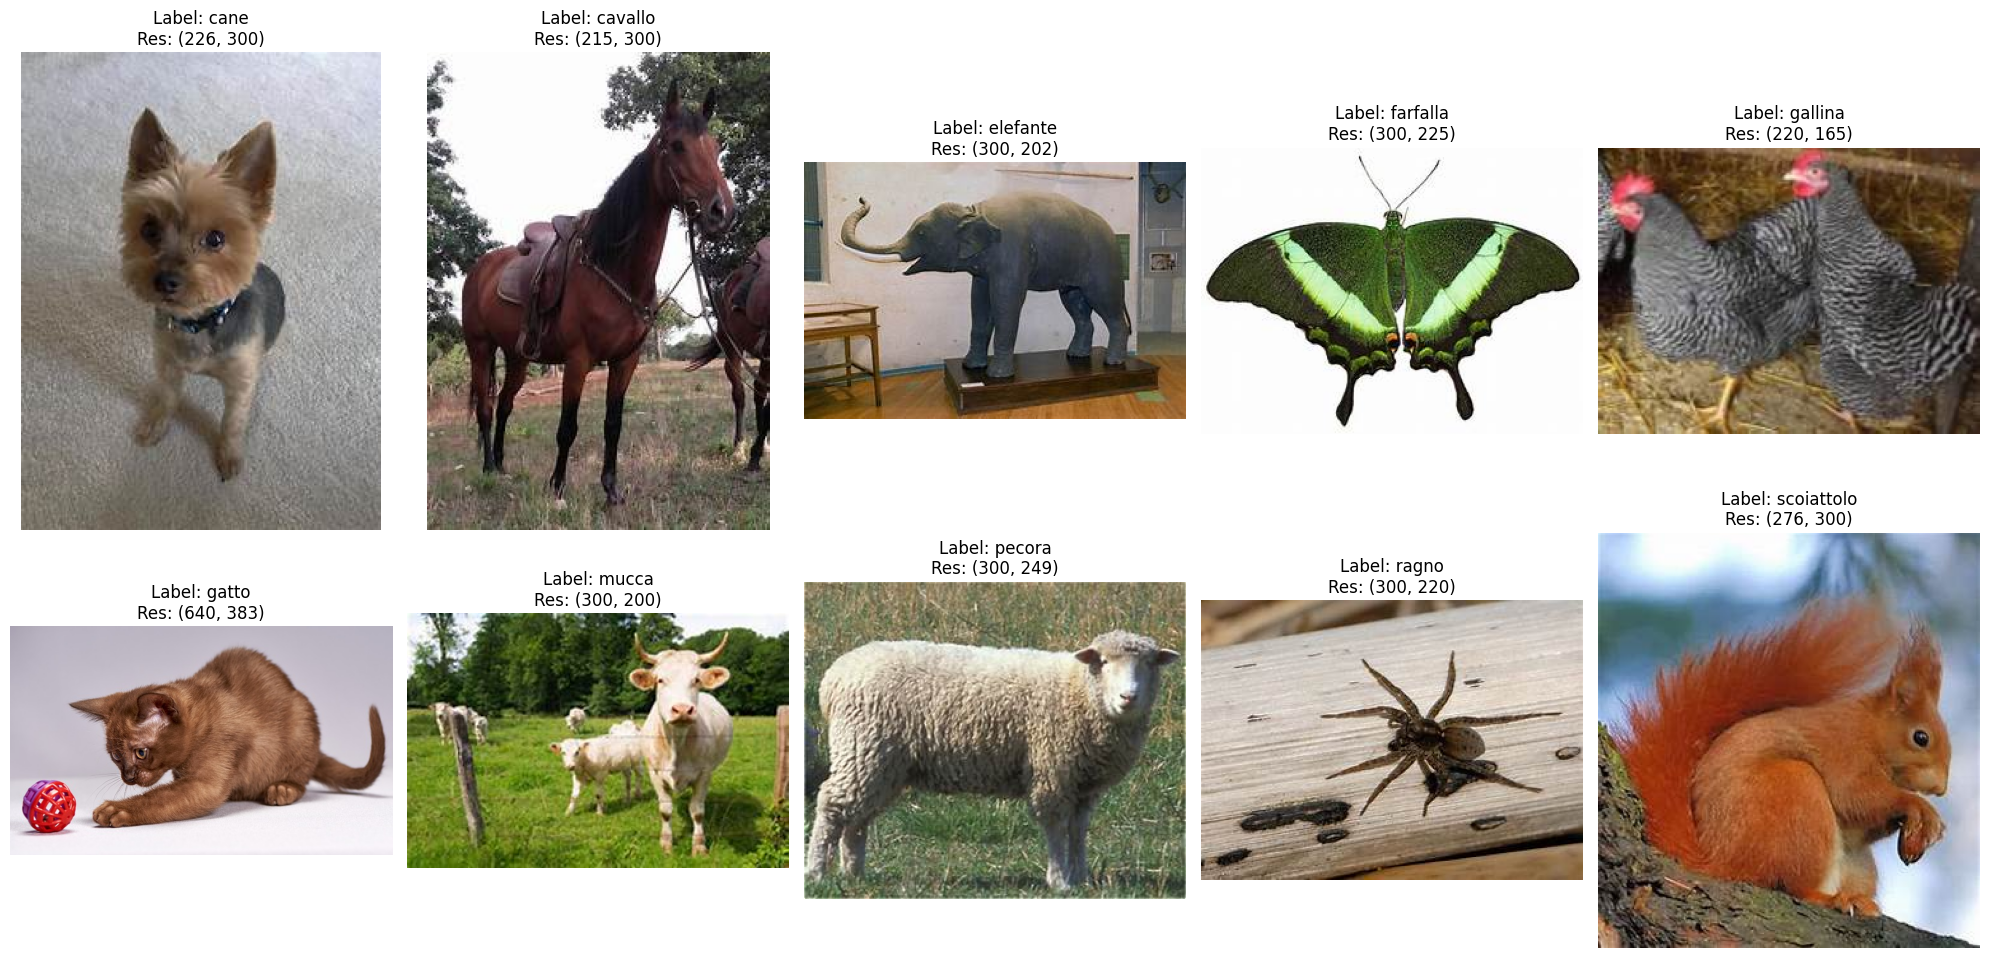

In [5]:
base_dir = './animal10/raw-img'
classes = sorted(os.listdir(base_dir))

# Setup plot 2 baris x 5 kolom
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

print("Menampilkan sampel gambar untuk verifikasi data...")

for i, class_name in enumerate(classes):
    class_path = os.path.join(base_dir, class_name)

    # Ambil file pertama di folder tersebut
    sample_file = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, sample_file)

    # Buka dan tampilkan
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {class_name}\nRes: {img.size}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Cek Sebaran Data

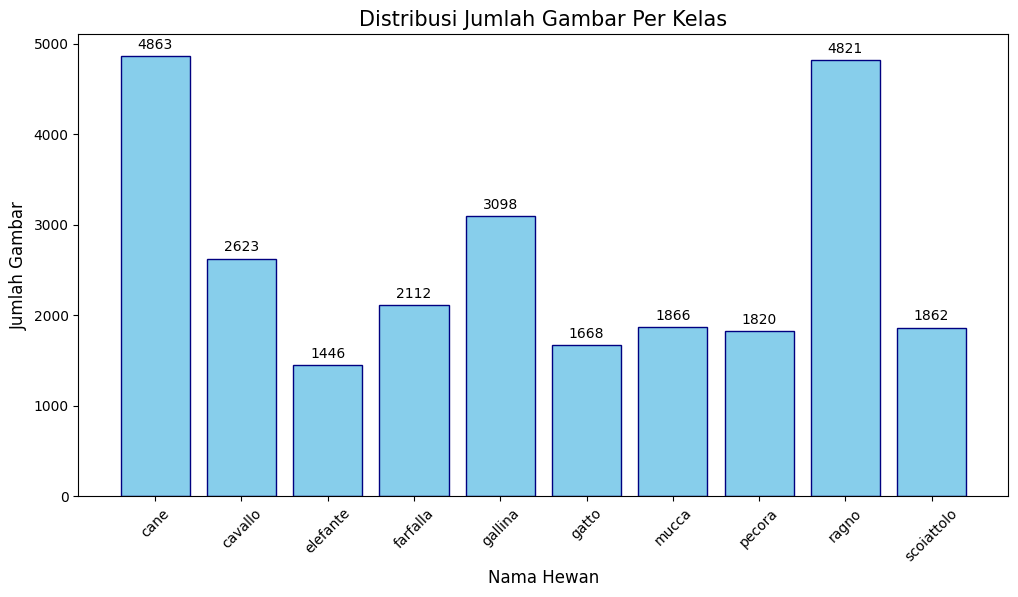

In [6]:
import matplotlib.pyplot as plt

# Data dari hasil scan Anda sebelumnya
labels = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
counts = [4863, 2623, 1446, 2112, 3098, 1668, 1866, 1820, 4821, 1862]

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue', edgecolor='navy')
plt.title('Distribusi Jumlah Gambar Per Kelas', fontsize=15)
plt.xlabel('Nama Hewan', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=45)

# Tambah angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, yval, ha='center', va='bottom')

plt.show()

### Splitting Dataset (Train, Validation, and Test Set)

Pada tahap ini, dataset yang awalnya terkumpul dalam satu folder besar akan dibagi menjadi tiga bagian terpisah sesuai dengan kriteria proyek:

1. Train Set (80%): Digunakan sebagai sumber utama bagi model untuk mempelajari pola visual dari setiap kelas hewan.

2. Validation Set (10%): Digunakan selama proses pelatihan untuk mengevaluasi performa model secara berkala (tuning) dan mendeteksi adanya overfitting.

3. Test Set (10%): Digunakan sebagai evaluasi akhir menggunakan data yang belum pernah dilihat sama sekali oleh model untuk menguji kemampuan generalisasi.

Pembagian ini dilakukan menggunakan library split-folders dengan fixed seed agar hasil pembagian konsisten (reproducible). Selain itu, dilakukan penyaringan otomatis agar dataset hanya berfokus pada 3 kelas target (Cane, Farfalla, Ragno) guna memastikan efisiensi training dan pencapaian akurasi maksimal.

In [7]:
# 1. Tentukan folder
input_folder = './animal10/raw-img'
output_folder = './dataset_final'

# 2. Proses Splitting dengan 3 rasio (Train, Val, Test)
splitfolders.ratio(input_folder, output=output_folder,
                   seed=1337, ratio=(.8, .1, .1),
                   group_prefix=None, move=False)

# 3. List kelas yang kita pilih
selected_classes = ['cane', 'farfalla', 'ragno']

# 4. Bersihkan folder agar hanya berisi 3 kelas tersebut di ketiga folder (train, val, test)
for folder_type in ['train', 'val', 'test']:
    current_path = os.path.join(output_folder, folder_type)
    if os.path.exists(current_path):
        all_folders = os.listdir(current_path)
        for folder in all_folders:
            if folder not in selected_classes:
                shutil.rmtree(os.path.join(current_path, folder))

print("Pemisahan Selesai! Sekarang Anda punya folder Train, Val, dan Test dengan 3 kelas pilihan.")

Copying files: 26179 files [00:04, 6013.12 files/s]


Pemisahan Selesai! Sekarang Anda punya folder Train, Val, dan Test dengan 3 kelas pilihan.


In [8]:
output_folder = './dataset_final'
subfolders = ['train', 'val', 'test']
classes = ['cane', 'farfalla', 'ragno']

# Hitung total keseluruhan dulu untuk persentase total
grand_total = 0
for sub in subfolders:
    for cls in classes:
        path = os.path.join(output_folder, sub, cls)
        grand_total += len(os.listdir(path)) if os.path.exists(path) else 0

print(f"{'Folder':<10} | {'Cane':<8} | {'Farfalla':<10} | {'Ragno':<8} | {'Total':<8} | {'Persentase'}")
print("-" * 75)

for sub in subfolders:
    counts = []
    for cls in classes:
        path = os.path.join(output_folder, sub, cls)
        count = len(os.listdir(path)) if os.path.exists(path) else 0
        counts.append(count)

    row_total = sum(counts)
    percentage = (row_total / grand_total) * 100

    print(f"{sub.upper():<10} | {counts[0]:<8} | {counts[1]:<10} | {counts[2]:<8} | {row_total:<8} | {percentage:.1f}%")

print("-" * 75)
print(f"{'TOTAL':<10} | {grand_total:<8}")

Folder     | Cane     | Farfalla   | Ragno    | Total    | Persentase
---------------------------------------------------------------------------
TRAIN      | 3890     | 1689       | 3856     | 9435     | 80.0%
VAL        | 486      | 211        | 482      | 1179     | 10.0%
TEST       | 487      | 212        | 483      | 1182     | 10.0%
---------------------------------------------------------------------------
TOTAL      | 11796   


### Data Preprocessing

### Cek Keseragaman Resolusi

In [9]:
# Path
base_dir = './animal10/raw-img'
resolutions = []

print("Sedang memindai resolusi seluruh gambar... Mohon tunggu.. ")

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                resolutions.append(img.size)

# Menghitung kemunculan setiap resolusi
res_counts = Counter(resolutions)

# 1. Ubah Counter ke DataFrame agar rapi
df_res = pd.DataFrame.from_dict(res_counts, orient='index').reset_index()
df_res.columns = ['Resolusi (WxH)', 'Jumlah Gambar']

# 2. Urutkan berdasarkan jumlah terbanyak
df_res = df_res.sort_values(by='Jumlah Gambar', ascending=False)

print(f"\n--- Ringkasan Resolusi Dataset ---")
print(f"Ditemukan {len(res_counts)} variasi resolusi berbeda!\n")

# 3. Tampilkan
display(df_res)

Sedang memindai resolusi seluruh gambar... Mohon tunggu.. 

--- Ringkasan Resolusi Dataset ---
Ditemukan 1002 variasi resolusi berbeda!



Resolusi (WxH)  Jumlah Gambar
4       (300, 225)           4397
0       (300, 200)           3281
34      (300, 300)           1192
1       (300, 169)           1048
358     (640, 426)            694
..             ...            ...
630   (3577, 5365)              1
632     (409, 640)              1
633     (640, 587)              1
602     (188, 194)              1
645     (484, 640)              1

[1002 rows x 2 columns]

### Resizing

In [10]:
# Parameter dasar
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

print("Memulai pemuatan dataset dari direktori...")

# Memuat Train Set
train_ds = tf.keras.utils.image_dataset_from_directory(
    './dataset_final/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Memuat Validation Set
val_ds = tf.keras.utils.image_dataset_from_directory(
    './dataset_final/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Memuat Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    './dataset_final/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Memulai pemuatan dataset dari direktori...
Found 9435 files belonging to 3 classes.
Found 1179 files belonging to 3 classes.
Found 1182 files belonging to 3 classes.


In [11]:
class_names = train_ds.class_names
print(f"\nNama kelas yang terdeteksi: {class_names}")

# Mengambil satu batch untuk cek dimensi
for images, labels in train_ds.take(1):
    print(f"Bentuk batch gambar: {images.shape}") # Harus (32, 150, 150, 3)
    print(f"Bentuk batch label : {labels.shape}") # Harus (32, 3)
    break


Nama kelas yang terdeteksi: ['cane', 'farfalla', 'ragno']
Bentuk batch gambar: (32, 150, 150, 3)
Bentuk batch label : (32, 3)


### Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),        # Membalik gambar
  layers.RandomRotation(0.1),             # Memutar gambar maks
  # layers.RandomZoom(0.2),                 # Zoom in/out maks
  # layers.RandomTranslation(0.1, 0.1),     # Menggeser gambar
])

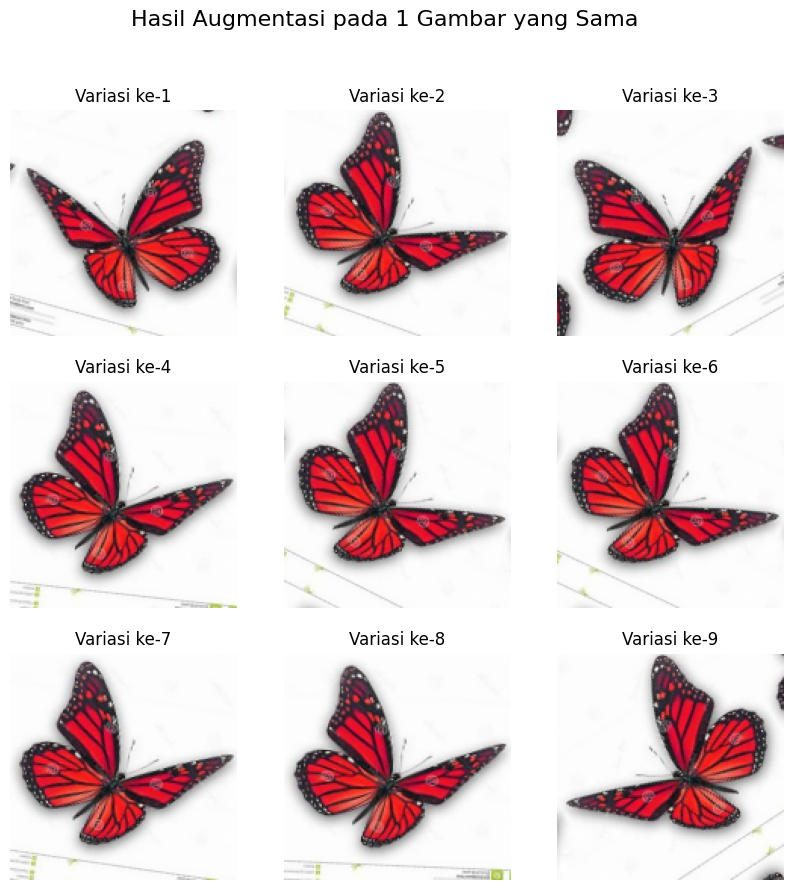

In [13]:
# Ambil 1 batch dari dataset
for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Terapkan augmentasi pada gambar yang sama
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

        # Tampilkan
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"Variasi ke-{i+1}")

plt.suptitle("Hasil Augmentasi pada 1 Gambar yang Sama", fontsize=16)
plt.show()

## Modelling

In [14]:
# 1. Menggunakan transfer learning MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 2. Arsitektur Model
model = tf.keras.models.Sequential([

    # Layer Preprocessing
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1, input_shape=(150, 150, 3)),
    data_augmentation,

    # Transfer Learning
    base_model,

    # Conv2D & Pooling Layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer Klasifikasi
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

# 3. Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callback Lebih Cerdas
class TargetCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96):
            print("\n...")
            self.model.stop_training = True

my_callbacks = [
    TargetCallback(),
    callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

/tmp/ipython-input-441/1899697175.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
print("Memulai ...")
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=my_callbacks
)

Memulai ...
Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9048 - loss: 0.5555 - val_accuracy: 0.9839 - val_loss: 0.0538 - learning_rate: 0.0010
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9696 - loss: 0.0966
...
295/295 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9696 - loss: 0.0965 - val_accuracy: 0.9805 - val_loss: 0.0775 - learning_rate: 0.0010


## Evaluasi dan Visualisasi

In [25]:
print("--- Evaluasi Model pada Data Test ---")

test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Hasil Akurasi Data Test: {test_accuracy * 100:.2f}%")
print(f"Hasil Loss Data Test: {test_loss:.4f}")

--- Evaluasi Model pada Data Test ---
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9836 - loss: 0.0674
Hasil Akurasi Data Test: 98.56%
Hasil Loss Data Test: 0.0570


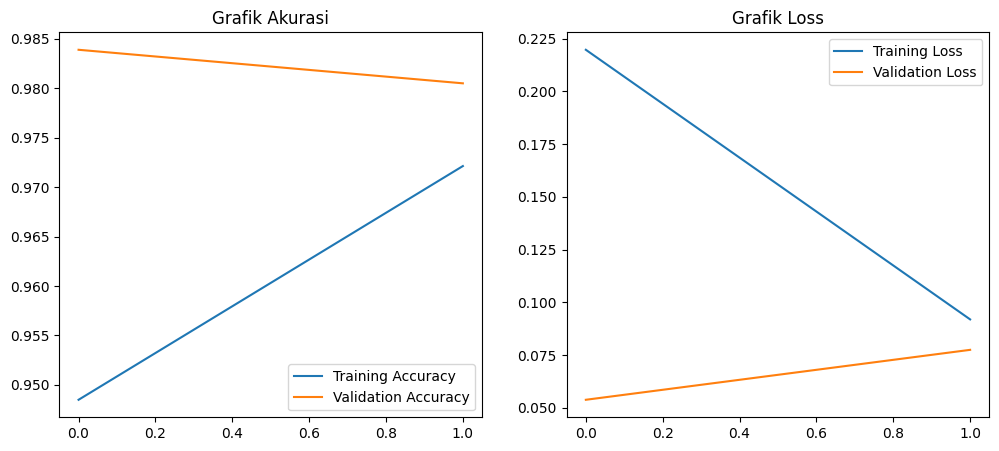

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Grafik Akurasi')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Grafik Loss')
plt.legend(loc='upper right')

plt.show()

## Konversi Model

In [19]:
base_dir = 'submission'

sub_folders = [
    'saved_model',
    'tfjs_model',
    'tflite'
]

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)


for folder in sub_folders:
    path = os.path.join(base_dir, folder)
    os.makedirs(path, exist_ok=True)

print("selesai")

selesai


In [20]:
# A. Simpan sebagai .keras
model.save('submission/my_model.keras')

# B. Simpan sebagai SavedModel
model.export('submission/saved_model')

# C. Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# D. Konversi ke TFJS
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'submission/tfjs_model')

print("selesai!")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_157')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140219469069008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219488782480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219467746192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219467750032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219467749840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219467745808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219467754256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219467752528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219467751376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140219467752336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1402

failed to lookup keras version from the file,
    this is likely a weight only file
selesai!


## Inference (Optional)

### SavedModel Tes

In [26]:
print("--- Evaluasi Model pada Data Test ---")

loaded_model = tf.keras.models.load_model('submission/my_model.keras')

test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Hasil Akurasi Data Test: {test_accuracy * 100:.2f}%")
print(f"Hasil Loss Data Test: {test_loss:.4f}")

--- Evaluasi Model pada Data Test ---
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9837 - loss: 0.0691
Hasil Akurasi Data Test: 98.56%
Hasil Loss Data Test: 0.0570


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


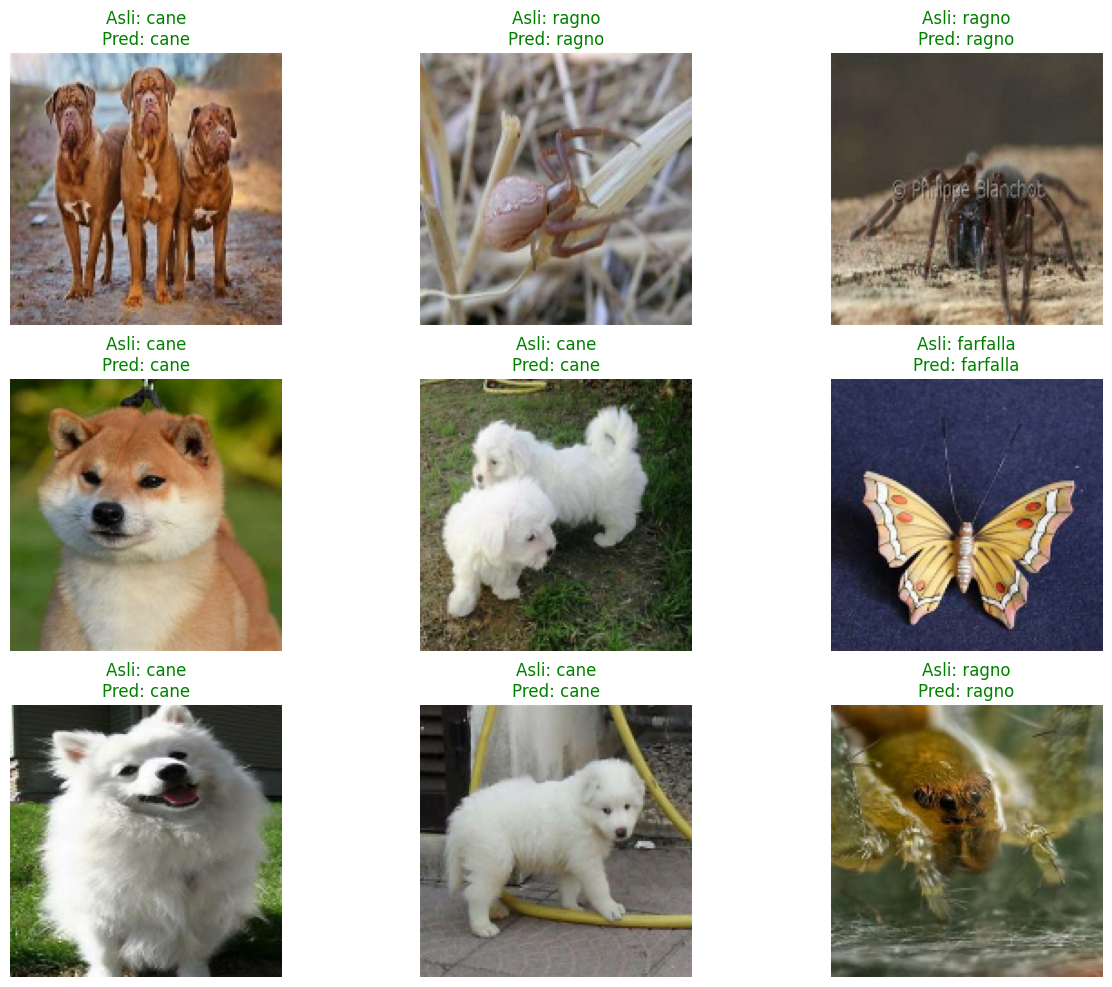

In [23]:
loaded_model = tf.keras.models.load_model('submission/my_model.keras')

# Ambil sampel data dari test_ds
for images, labels in test_ds.take(1):
    predictions = loaded_model.predict(images)
    class_names = ['cane', 'farfalla', 'ragno']

    plt.figure(figsize=(15, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        actual_idx = np.argmax(labels[i])
        pred_idx = np.argmax(predictions[i])

        color = 'green' if actual_idx == pred_idx else 'red'
        plt.title(f"Asli: {class_names[actual_idx]}\nPred: {class_names[pred_idx]}", color=color)
        plt.axis('off')
    plt.show()